# Proyecto 03 - Procesamiento del Lenguaje Natural


## TP III GASPAR GONZALEZ WULFSOHN

Vamos a trabajar con el corpus de críticas sobre productos adquiridos por usuarios de la plataforma AMAZON. Para realizar este informe tuvimos en cuenta la suiguiente licencia.

LICENSE

By accessing the Multilingual Amazon Reviews Corpus ("Reviews Corpus"), you agree that the Reviews Corpus is an Amazon Service subject to the Amazon.com Conditions of Use (https://www.amazon.com/gp/help/customer/display.html/ref=footer_cou?ie=UTF8&nodeId=508088) and you agree to be bound by them, with the following additional conditions:

In addition to the license rights granted under the Conditions of Use, Amazon or its content providers grant you a limited, non-exclusive, non-transferable, non-sublicensable, revocable license to access and use the Reviews Corpus for purposes of academic research. You may not resell, republish, or make any commercial use of the Reviews Corpus or its contents, including use of the Reviews Corpus for commercial research, such as research related to a funding or consultancy contract, internship, or other relationship in which the results are provided for a fee or delivered to a for-profit organization. You may not (a) link or associate content in the Reviews Corpus with any personal information (including Amazon customer accounts), or (b) attempt to determine the identity of the author of any content in the Reviews Corpus. If you violate any of the foregoing conditions, your license to access and use the Reviews Corpus will automatically terminate without prejudice to any of the other rights or remedies Amazon may have.

## Exploración de datos y Procesamiento del Lenguaje Natural

### Importamos las librerías necesarias para realizar el trabajo


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import itertools
import nltk
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.svm import SVC
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('spanish')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize.toktok import ToktokTokenizer
import re
import string
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup
import unicodedata
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('spanish')
stopword_list.remove('no')
import spacy  
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score
import nltk
#nltk.download()
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn
from unicodedata import normalize
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import xgboost as xgb

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gaspa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gaspa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Carga de datos
### Cargamos los datos en formato .json
Vamos a cargar los datos con la función pd.read_json de Pandas y obtener una idea precisa del dataframe

In [2]:
df_train = pd.read_json ('dataset_es_train.json', lines = True)

In [3]:
df_train.shape

(200000, 8)

In [4]:
df_test = pd.read_json ('dataset_es_test.json', lines = True)

In [5]:
df_test.shape

(5000, 8)

In [6]:
df_dev = pd.read_json ('dataset_es_dev.json', lines = True)

In [7]:
df_dev.shape

(5000, 8)

Vamos a unir todos los datos en un mismo dataframe para poder aprovechar la mayor cantidad de datos posibles

In [8]:
# Unimos todos los datos en un mismo dataframe
df_merge = [df_test, df_train, df_dev]
df = pd.concat(df_merge )


In [9]:
# Obtenemos la cantidad de filas y columnas total del dataframe
df.shape

(210000, 8)

Vamos arealizar una muestra aleatoria con el objetivo de reducir el tamaño y poder trabajar con los datos

In [10]:
# Muestra aleatoria de 50000 instancias
experiment_size = int(50000)
completerandom_idx = df_train.sample(int(experiment_size),random_state = 21).index
df = df_train.loc[completerandom_idx,:]


In [11]:
# 50.000 filas y 8 columnas
df.shape

(50000, 8)

Vamos a realizar un gráfico para entender cuantas instancias hay en cada calificación

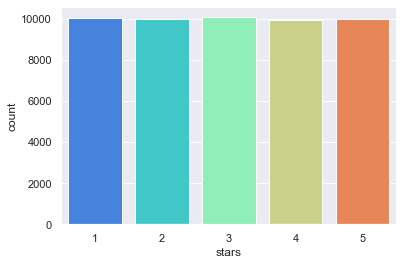

In [12]:
# Realizamos un countplot con seaborn
sns.countplot(x='stars',data=df,palette='rainbow')

Existen casi la misma cantidad de instancias por calificación. 

Vamos a agrupar según las estrellas.

In [13]:
# Utilizamos la función groupby y luego obtenemos la cantidad de instancias por estrella calificada
stars = df.groupby('stars')
stars.size()

stars
1    10010
2     9976
3    10071
4     9949
5     9994
dtype: int64

Vamos a filtrar el dataframe de modo tal que todas las estrellas tengan la misma cantidad de instancias. 

In [14]:
# Unimos todos los datos en un mismo dataframe
df_merge = [df_test, df_train, df_dev]
df = pd.concat(df_merge )


In [15]:
df.shape

(210000, 8)

Volvemos a obtener una muestra aleatoria 

In [16]:
# Muestra aleatoria de 60000 instancias
experiment_size = int(60000)
completerandom_idx = df_train.sample(int(experiment_size),random_state = 21).index
df = df_train.loc[completerandom_idx,:]

In [17]:
df.shape

(60000, 8)

Realizamos un slice y luego unimos los dataframes en uno solo. El objetivo es tener la misma cantidad de instancias por estrella. De esa forma podemos obtener un modelo benchmark que sea la posibilidad de acertar entre 5 instancias. 

In [18]:
# Realizamos un filtrado por número de estrellas y luego un slice de 10000
stars_1 = pd.DataFrame(df[df.stars == 1])[:10000]
stars_2 = pd.DataFrame(df[df.stars == 2])[:10000]
stars_3 = pd.DataFrame(df[df.stars == 3])[:10000]
stars_4 = pd.DataFrame(df[df.stars == 4])[:10000]
stars_5 = pd.DataFrame(df[df.stars == 5])[:10000]

In [19]:
# Unimos en un mismo dataframe
df_merge = [stars_1, stars_2, stars_3, stars_4, stars_5]
df = pd.concat(df_merge )

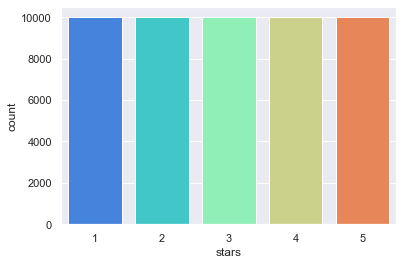

In [20]:
# Realizamos un countplot con seaborn
sns.countplot(x='stars',data=df,palette='rainbow')

En el gráfico podemos observar una distribución homogénea.

In [21]:
# Agrupamos por la columnas 'stars'
stars = df.groupby('stars')
stars.size()

stars
1    10000
2    10000
3    10000
4    10000
5    10000
dtype: int64

Finalmente obtuvimos la misma cantidad de instancias por número de estrellas calificadas para comenzar a trabajar

## Ingeniería de datos

Vamos a añadir algunas features relacionadas con los textos de las críticas.
    
    1. Largo del texto.
    
    2. Número de palabras

Luego intentaremos contestar algunas preguntas en relación a esas nuevas variables:
¿Influye el largo del texto en el tipo de calificación? ¿y el número de palabras?

In [22]:
# Largo del texto
df['text_length'] = df['review_body'].apply(len)

In [23]:
# Número de palabras
df['nb_words'] = df['review_body'].apply(lambda x: len(x.split(" ")))

In [24]:
df.head(3)

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,text_length,nb_words
6468,es_0476668,product_es_0773990,reviewer_es_0443238,1,"A la espera de que llegue, tres días desde la ...",No me ha llegado,es,home,101,21
14064,es_0372690,product_es_0019996,reviewer_es_0925676,1,"El producto está muy bien, fácil de montar, pr...",El problema está en los plazos de entrega.,es,home,325,61
20862,es_0127411,product_es_0301699,reviewer_es_0468082,1,"Después de 2 meses, ni he recibido las diadema...",MUY MALA EXPERIENCIA,es,apparel,77,15


Realiamos unas estadísticas básicas sobre el feature 'text_length'

In [25]:
(df.text_length).describe().round()

count    50000.0
mean       151.0
std        131.0
min         17.0
25%         68.0
50%        120.0
75%        186.0
max       2023.0
Name: text_length, dtype: float64

Vemos que hasta el tercer cuartil el largo del texto es de 186. Vamos a buscar la crítica más larga y ver que calificación tuvo.

In [26]:
# Buscamos la crítica más larga
max_length = (df.text_length == 2023)
print(df[max_length].review_body)

27939    El producto no esta mal en cuanto a sonido y f...
Name: review_body, dtype: object


In [27]:
df[max_length]

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,text_length,nb_words
27939,es_0382650,product_es_0150804,reviewer_es_0769920,1,El producto no esta mal en cuanto a sonido y f...,No lo puedo recomendar para hacer deporte,es,wireless,2023,388


Vemos que la crítica más extensa tuvo una califiación mala, de una estrella. ¿Las críticas extensas tienden a ser malas?

In [28]:
# Buscamos la crítica más extensa
df[df['text_length'] == 2023]['review_body'].iloc[0]

'El producto no esta mal en cuanto a sonido y funcionamient, ademas habia leido reviews muy buenas, además da una primera sensación de calidad muy buena, pero no puedo recomendarlo para hacer deporte de ninguna de las maneras. El primer dia no se escuchaba bien, resulta que a base de poner y quitar los auriculares varias veces al final se fue solucionando poco a poco, debía venir con el conector sucio o a saber. Aun asi a veces si giras el conector se corta el audio. El tacto de los botones deja bastante que desear, sobretodo el de encendido que en mi caso no sabes si esta pulsado o no a no ser que mires la pantalla a ver si ha hecho algo. La pantalla es pésima a la luz del día, incluso en un dia nublado no se ve, me ha sido imposible buscar una canción mirando la lista ya que a no ser que fuese de noche en la calle era imposible leer la pantalla ni siquiera tapandola con ambas manos, muy poco brillo y no es ajustable. La calidad de sonido excepcional una vez hace buen contacto, todo h

Evidentemente es un usuario que no está para nada conforme con el producto

Vamos a realizar histogramas para entender la distribución en el feature 'text_length'

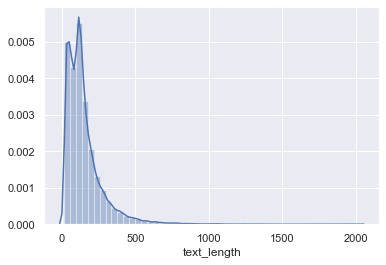

In [29]:
# Histograma con seaborn
sns.distplot(df.text_length)

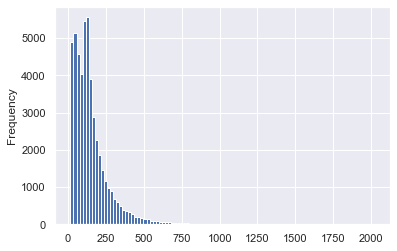

In [30]:
# Histograma con matloplib
df['text_length'].plot(bins=100, kind='hist') 

En ambos gráficos observamos un sesgo hacia la derecha y una distribución bimodal. La mayor frecuencia se encuentra en dos picos, las críticas hasta 100 palabras y de alrededor de 200. 

Las críticas que tienen una longitud mayor a 250 palabras tien una frecuencia menor.

Vamos a realizar un gráfico para identificar si hay alguna relación entre el largo del texto y el tipo de críticas.

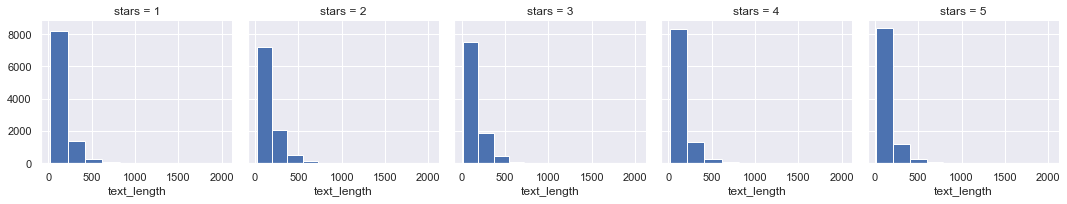

In [31]:
# Realizamos un gráfico de barras con seaborn
g = sns.FacetGrid(df,col='stars')
g.map(plt.hist,'text_length')

Las ditribuciones del largo de texto en relación a las calificaciones son homogéneas, no habría una correlación entre el número de palabras y el número de estrellas. Vamos a realizar un gráfico de boxplot para confirmar.

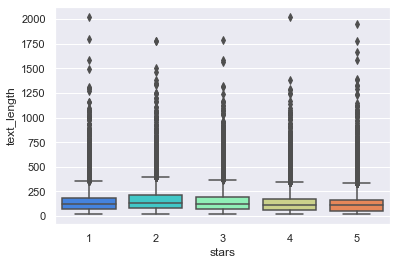

In [32]:
# Realizamos un gráfico de boxplot con seaborn
sns.boxplot(x='stars',y='text_length',data=df,palette='rainbow')

Nuevamente podemos observar que las distribuciones del largo del texto en cada estrella son similares, concluyendo que no existe una relación entre el largo del texto  y la calificación. 

## Preprocesamiento del texto

Vamos a realizar un preprocesamiento del texto, quitando las stopword en español y signos, llevando todos los caracteres a minúscula, stemmizando y finalmente tokenizando. 

In [33]:
# Instanciamos las stopwords del español
stopwords = nltk.corpus.stopwords.words('spanish')


In [34]:
# Importamos la función que nos permite Stemmizar de nltk y definimos el stemmer
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

In [35]:
lista_criticas=[]
for critica in df.review_body:
    # Vamos a reemplzar los caracteres que no sean letras por espacios
    critica=re.sub("[^a-zA-Z]"," ",str(critica))
    # Pasamos todo a minúsculas
    critica=critica.lower()
    # Tokenizamos para separar las palabras del titular
    critica=nltk.word_tokenize(critica)
    # Eliminamos las palabras de menos de 3 letras
    critica = [palabra for palabra in critica if len(palabra)>3]
    # Sacamos las Stopwords
    critica = [palabra for palabra in critica if not palabra in stopwords]
    
    ## Hasta acá Normalizamos, ahora a stemmizar
    
    # Aplicamos la funcion para buscar la raiz de las palabras
    critica=[stemmer.stem(palabra) for palabra in critica]
    # Por ultimo volvemos a unir el titular
    critica=" ".join(critica)
    
    # Vamos armando una lista con todos los titulares
    lista_criticas.append(critica)
    #dataset["titular_normalizado"] = titular_list


También vamos a retirar los acentos y normalizamos utilizando la librería 'unicodedata'

In [36]:
# Agregamos la lista al dataframe
df['criticas_stem'] =  lista_criticas

In [37]:
# Removemos los acentos y normalizamos con una función de la librería 'unicodedata'
remove_accent = lambda text: normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8", "ignore")
# Creamos una nueva columna con las críticas normalizadas y procesadas
df['criticas_stem'] = df['criticas_stem'].apply(remove_accent)


In [38]:
df.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,text_length,nb_words,criticas_stem
6468,es_0476668,product_es_0773990,reviewer_es_0443238,1,"A la espera de que llegue, tres días desde la ...",No me ha llegado,es,home,101,21,espera llegu tre fecha entrega primera pasa am...
14064,es_0372690,product_es_0019996,reviewer_es_0925676,1,"El producto está muy bien, fácil de montar, pr...",El problema está en los plazos de entrega.,es,home,325,61,producto bien montar precio razon compr nico p...
20862,es_0127411,product_es_0301699,reviewer_es_0468082,1,"Después de 2 meses, ni he recibido las diadema...",MUY MALA EXPERIENCIA,es,apparel,77,15,despu mese recibido diadema devuelto dinero
35994,es_0500471,product_es_0778859,reviewer_es_0824370,1,Te mandan los artículos sin haberlos pagado.,¡¡¡ Que guapo !!!,es,pc,44,7,mandan culo haberlo pagado
27746,es_0015129,product_es_0261843,reviewer_es_0782745,1,"El producto aún no ha llegado, tenía que llega...",Estafa,es,toy,111,22,producto llegado llegar mayo sigo esperando es...


Vamos a retirar las columnas que consideramos redundantes

In [39]:
# Lenguage, todas son en español
df_lan = df.groupby('language')
pd.DataFrame(df_lan)

,0,1
0,es,review_id product_id ...


Retiramos las columnas que no vamos a utilizar

In [40]:
# Utilizamos .drop de pandas para retirar las columnas que consideramos irrelevantes o redundantes
df = df.drop(['review_id', 'review_title', 'language', 'review_body'], axis = 1)

Retiramos el texto de las features product_id y reviewer_id


In [41]:
# Utilizamos funciones lamda para retirar el texto
df['product_id'] = df['product_id'].map(lambda x: x.lstrip('product_es_'))
df['reviewer_id'] = df['reviewer_id'].map(lambda x: x.lstrip('reviewer_es_'))

In [42]:
df.head()

,product_id,reviewer_id,stars,product_category,text_length,nb_words,criticas_stem
6468,0773990,0443238,1,home,101,21,espera llegu tre fecha entrega primera pasa am...
14064,0019996,0925676,1,home,325,61,producto bien montar precio razon compr nico p...
20862,0301699,0468082,1,apparel,77,15,despu mese recibido diadema devuelto dinero
35994,0778859,0824370,1,pc,44,7,mandan culo haberlo pagado
27746,0261843,0782745,1,toy,111,22,producto llegado llegar mayo sigo esperando es...


Vamos a analizar el dataframe en relación al tipo de producto para entender un poco más cuál es su relación con las calificaciones. 

¿Habrá algún tipo de producto que tenga una tendencia a recibir malas o buenas críticas?

In [43]:
# Compiamos el dataframe para filtrar por categoría de producto
df2 = df.copy()

In [44]:
# Creamos un dataframe nuevo con las features 'stars' y 'product_category' y realizamos unas estadísticas básicas
filt = ['stars', 'product_category']
art = df2[filt]
art.describe().round()

,stars
count,50000.0
mean,3.0
std,1.0
min,1.0
25%,2.0
50%,3.0
75%,4.0
max,5.0


Según las estadísticas, la distribución del número de estrellas es homogénea.

In [45]:
# Agrupamos por tipo de producto
art = art.groupby('product_category').sum().sort_values('stars', ascending=False)

In [46]:
art.head()

,stars
product_category,
home,20177
wireless,18311
toy,10307
sports,9982
pc,8576


Vemos que los tipos de productos con más instancias son 'home', 'wireless' y 'toy'


Vamos a realizar un dataframe que nos permita observar la cantidad de instancias por producto y el promedio de la calificación en estrellas

In [47]:
# Agrupamos pot tipo de producto
ins = df2.groupby('product_category').size()
ins.head()

product_category
apparel         1444
automotive      1784
baby_product    1148
beauty          1825
book            1360
dtype: int64

In [48]:
# Agregamos la columnas al df
art['instancias_producto'] = ins

In [49]:
# Obtenemos el promedio de estrellas por producto y agregamos la columna.
art['promedio_producto'] = art.stars/ins
art = art.sort_values('promedio_producto', ascending =  False)
art = art.reset_index()
art.head()

,product_category,stars,instancias_producto,promedio_producto
0,book,4655,1360,3.422794
1,digital_ebook_purchase,1547,457,3.385120
2,luggage,2739,827,3.311971
3,grocery,909,279,3.258065
4,musical_instruments,1286,399,3.223058


Realizamos unas estadísticas básicas

In [50]:
art.promedio_producto.describe()

count    30.000000
mean      3.055031
std       0.153041
min       2.708654
25%       2.980697
50%       3.051553
75%       3.096157
max       3.422794
Name: promedio_producto, dtype: float64

Nuevamente obtenemos una distribución muy homogénea de la cantidad de estrellas por producto. Los valores en promedio son de 3 estrellas, sin grandes diferencias entre las calificaciones de los productos. Vamos a graficar para obtener una idea más clara.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text major ticklabel objects>)

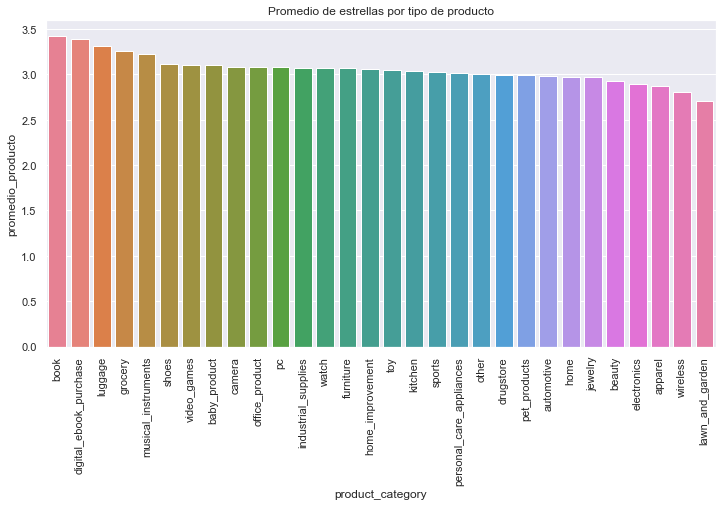

In [51]:
# Realizamos un gráfico de barras con seaborn
plt.figure(figsize=(12,6))
sns.barplot(x = 'product_category', y = 'promedio_producto', data= art, palette = 'husl')
plt.title('Promedio de estrellas por tipo de producto')
plt.xticks(rotation = 90)

EL promedio de calificaciones por productos es muy similar en todos, en un rango de 2.7 a 3.4

Vamos a realizar un boxplot para ver los valores atípicos.

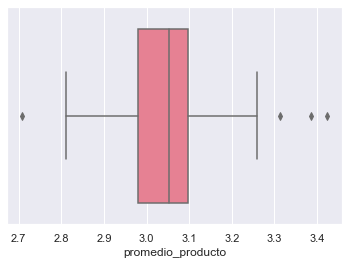

In [52]:
# Realizamos un boxplot con seaborn
sns.boxplot(x ='promedio_producto',  data= art, color = 'r', palette = 'husl')

Hay pocos valores atípicos y la distancia entre ellos y la media no es amplio.

#### Respuesta a la pregunta: ¿Habrá alguna tendencia en los tipos de productos a recibir buenas o malas críticas?

Según lo analizado, podemos concluir que los tipos de prodcutos suelen recibir una calificació muy similiar entre ellos, por lo tanto no existe alguna tendencia hacia ser calificados de manera negativa o positiva. 

En relación a la homogeneidad en las calificaciones por tipos de productos, podemos considerar que posiblemente el tipo de producto no sea una variable que influya en el modelo al momento de realizar una predicción.



## Frecuencia de palabras en las críticas
Vamos a tokenizar las palabras y comparar la frecuencia de las mismas mediante dos formas diferentes: FreqDist de la librería NLTK y TFIDF de Sklearn

Finalmente, intentaremos obtener información para responder a la siguiente pregunta: ¿Hay palabras que se asocien a críticas positivas o negativas?

In [53]:
# Instanciams las criticas
criticas = df.criticas_stem

In [54]:
# Número de palabras en todas las críticas
text = " ".join(review for review in criticas)
print ("Hay {} palabras en todas las críticas.".format(len(text)))

Hay 4246606 palabras en todas las críticas.


In [55]:
# Tokenizamos
todas_las_criticas = []
for i in range(df.shape[0]):
    critic = df.iloc[i].criticas_stem
    critic = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(critic)

    todas_las_criticas.append(critic)

In [56]:
# SLice con las primeras 
todas_las_criticas = list(itertools.chain(*todas_las_criticas))
todas_las_criticas[0:10]

['espera',
 'llegu',
 'tre',
 'fecha',
 'entrega',
 'primera',
 'pasa',
 'amazon',
 'producto',
 'bien']

In [57]:
# Obtenemos la frecuencias de cada palabra
freq = nltk.FreqDist(todas_las_criticas)
freq

FreqDist({'bien': 13141, 'calidad': 7862, 'producto': 6435, 'precio': 5730, 'buena': 5225, 'pequ': 3424, 'bastant': 3359, 'buen': 2863, 'funciona': 2789, 'hace': 2712, ...})

In [58]:
# Realizamos un dataframe con la frecuencia de cada palabra
frecuencias = pd.DataFrame(list(freq.items()), columns = ['Palabra',"Frecuencia"])
frecuencias = frecuencias.sort_values('Frecuencia', ascending = False)
frecuencias.head()

,Palabra,Frecuencia
9,bien,13141
171,calidad,7862
8,producto,6435
11,precio,5730
789,buena,5225


In [59]:
mas_frec = frecuencias[0:50]
mas_frec

,Palabra,Frecuencia
9,bien,13141
171,calidad,7862
8,producto,6435
11,precio,5730
789,buena,5225
54,pequ,3424
1014,bastant,3359
173,buen,2863
69,funciona,2789
369,hace,2712


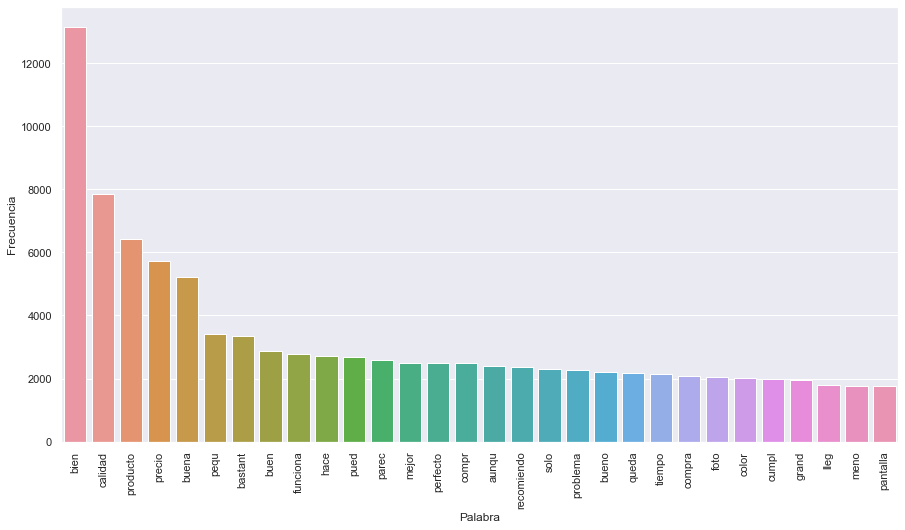

In [60]:
# Graficamos la frecuencia de las palabras
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = frecuencias.iloc[:30].Palabra, y = frecuencias.iloc[:30].Frecuencia)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

En el gráfico se observa que las existen 5 palabras con una fracuencias notoriamente mayor que el resto. Al estar presentes en gran cantidad de críticas, pueden no ser útiles para el modelo al momento de predecir una calificación porque no aportan información relevante. En ese sentido, es útil aplicar la técnica de TF-IDF, en el cual se asigna un peso bajo o 0 a palabras que se encuentren con una frecuencia alta. 

In [61]:
# Separamos en diferentes dataframes según las calificaciones. 
stars_1 = pd.DataFrame(df[df.stars == 1])
stars_2 = pd.DataFrame(df[df.stars == 2])
stars_3 = pd.DataFrame(df[df.stars == 3])
stars_4 = pd.DataFrame(df[df.stars == 4])
stars_5 = pd.DataFrame(df[df.stars == 5])

In [62]:
# Obtenenmos las primeras 5 instancias
stars_1.head()

,product_id,reviewer_id,stars,product_category,text_length,nb_words,criticas_stem
6468,0773990,0443238,1,home,101,21,espera llegu tre fecha entrega primera pasa am...
14064,0019996,0925676,1,home,325,61,producto bien montar precio razon compr nico p...
20862,0301699,0468082,1,apparel,77,15,despu mese recibido diadema devuelto dinero
35994,0778859,0824370,1,pc,44,7,mandan culo haberlo pagado
27746,0261843,0782745,1,toy,111,22,producto llegado llegar mayo sigo esperando es...


In [63]:
#Imprimimos cuántas palabras hay por cada calificación
text = " ".join(review for review in stars_1.criticas_stem)
print ("Hay {} palabras en críticas con 1 estrella.".format(len(text)))

Hay 855461 palabras en críticas con 1 estrella.


In [64]:
star1 = []
for i in range(stars_1.shape[0]):
    critic = stars_1.iloc[i].criticas_stem
    critic = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(critic)

    star1.append(critic)

star1 = list(itertools.chain(*star1))


In [65]:
freq = nltk.FreqDist(star1)
frecuencias = pd.DataFrame(list(freq.items()), columns = ['Palabra',"Frecuencia"])
frecuencias = frecuencias.sort_values('Frecuencia', ascending = False)
frecuencias.head()

,Palabra,Frecuencia
8,producto,1898
9,bien,1116
171,calidad,1083
39,llegado,882
559,recomiendo,732


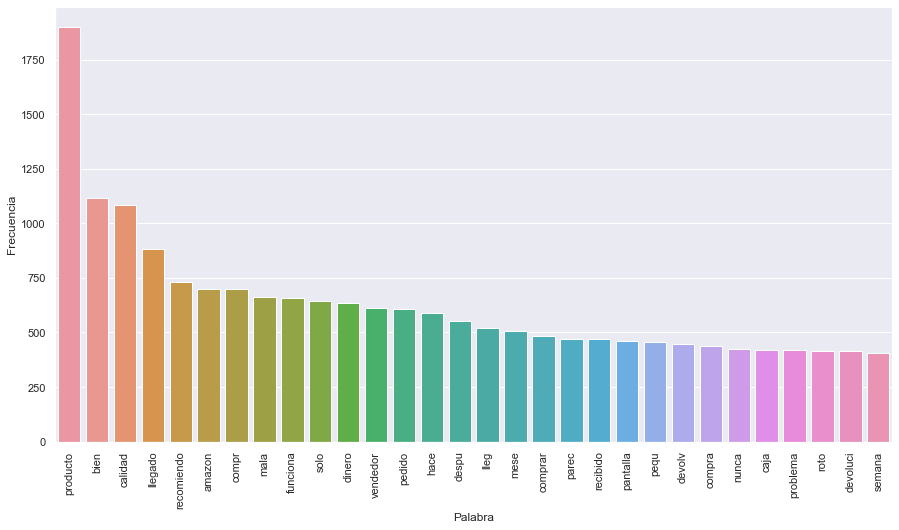

In [66]:
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = frecuencias.iloc[:30].Palabra, y = frecuencias.iloc[:30].Frecuencia)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

Hay tres palabras con una notoria mayor frecuencia en críticas con 1 estrella: 'producto', 'bien' y 'calidad'

In [67]:
# Instanciamos las primeras 5 palabras con mayor frecuencia
text = list(frecuencias.Palabra[0:5])
text = ', '.join(text)

In [68]:
print ("Las 5 palabras con mayor frecuencia en críticas con 1 estrella son: {}.".format(text))

Las 5 palabras con mayor frecuencia en críticas con 1 estrella son: producto, bien, calidad, llegado, recomiendo.


In [69]:
text = " ".join(review for review in stars_2.criticas_stem)
print ("Hay {} palabras en críticas con 2 estrellas.".format(len(text)))

Hay 930798 palabras en críticas con 2 estrellas.


In [70]:
star2 = []
for i in range(stars_2.shape[0]):
    critic = stars_2.iloc[i].criticas_stem
    critic = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(critic)

    star2.append(critic)

star2 = list(itertools.chain(*star2))

In [71]:
freq = nltk.FreqDist(star2)
frecuencias = pd.DataFrame(list(freq.items()), columns = ['Palabra',"Frecuencia"])
frecuencias = frecuencias.sort_values('Frecuencia', ascending = False)
frecuencias.head()

,Palabra,Frecuencia
17,bien,2425
42,calidad,1447
62,producto,1210
239,precio,898
225,pequ,816


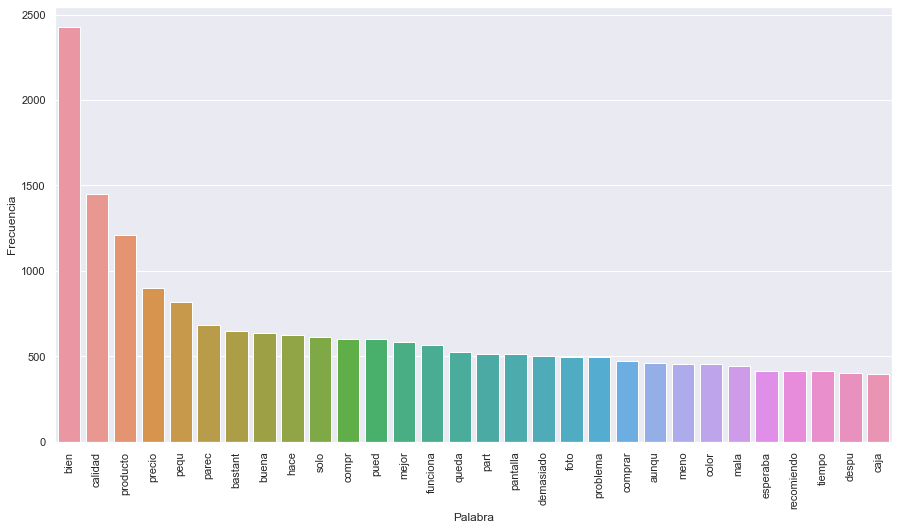

In [72]:
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = frecuencias.iloc[:30].Palabra, y = frecuencias.iloc[:30].Frecuencia)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

Las tres palabras con mayor frecuencia se repiten en las críticas con 2 estrellas

In [73]:
# Instanciamos las primeras 5 palabras con mayor frecuencia
text = list(frecuencias.Palabra[0:5])
text = ', '.join(text)

In [74]:
# Imprimimos las primeras 5 palabras con mayor frecuencia
print ("Las 5 palabras con mayor frecuencia en críticas con 2 estrellas son: {}.".format(text))

Las 5 palabras con mayor frecuencia en críticas con 2 estrellas son: bien, calidad, producto, precio, pequ.


In [75]:
text = " ".join(review for review in stars_3.criticas_stem)
print ("Hay {} palabras en críticas con 3 estrellas.".format(len(text)))

Hay 855355 palabras en críticas con 3 estrellas.


In [76]:
star3 = []
for i in range(stars_3.shape[0]):
    critic = stars_3.iloc[i].criticas_stem
    critic = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(critic)

    star3.append(critic)

star3 = list(itertools.chain(*star3))

In [77]:
freq = nltk.FreqDist(star3)
frecuencias = pd.DataFrame(list(freq.items()), columns = ['Palabra',"Frecuencia"]).sort_values('Frecuencia', ascending = False)
#frecuencias = frecuencias.sort_values('Frecuencia', ascending = False)
frecuencias.head()

,Palabra,Frecuencia
32,bien,3557
45,calidad,1507
7,precio,1305
131,producto,1057
135,pequ,904


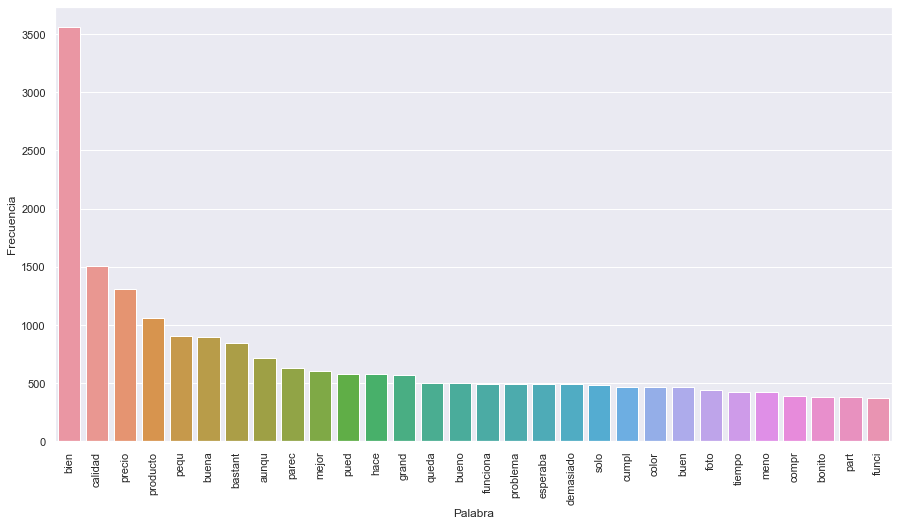

In [78]:
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = frecuencias.iloc[:30].Palabra, y = frecuencias.iloc[:30].Frecuencia)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

En las críticas con 3 estrellas, se repiten: 'bien' y 'calidad' como las palabras con mayor frecuencia. 

In [79]:
# Instanciamos las primeras 5 palabras con mayor frecuencia
text = list(frecuencias.Palabra[0:5])
text = ', '.join(text)

In [80]:
# Imprimimos las primeras 5 palabras con mayor frecuencia
print ("Las 5 palabras con mayor frecuencia en críticas con 3 estrellas son: {}.".format(text))

Las 5 palabras con mayor frecuencia en críticas con 3 estrellas son: bien, calidad, precio, producto, pequ.


In [81]:
text = " ".join(review for review in stars_4.criticas_stem)
print ("Hay {} palabras en críticas con 4 estrellas.".format(len(text)))

Hay 812608 palabras en críticas con 4 estrellas.


In [82]:
star4 = []
for i in range(stars_4.shape[0]):
    critic = stars_4.iloc[i].criticas_stem
    critic = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(critic)

    star4.append(critic)

star4 = list(itertools.chain(*star4))

In [83]:
freq = nltk.FreqDist(star4)
frecuencias = pd.DataFrame(list(freq.items()), columns = ['Palabra',"Frecuencia"]).sort_values('Frecuencia', ascending = False)
#frecuencias = frecuencias.sort_values('Frecuencia', ascending = False)
frecuencias.head()

,Palabra,Frecuencia
3,bien,3633
22,calidad,1802
16,precio,1785
108,buena,1630
15,producto,1117


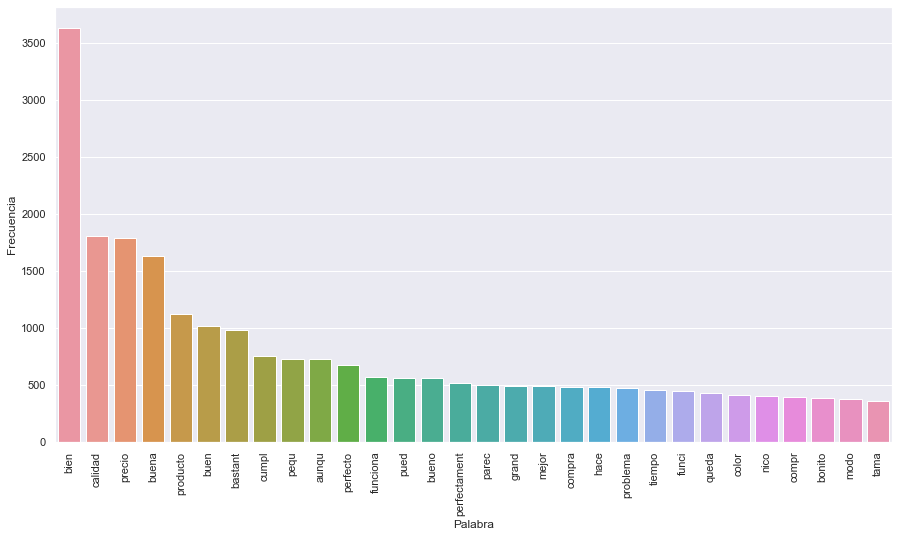

In [84]:
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = frecuencias.iloc[:30].Palabra, y = frecuencias.iloc[:30].Frecuencia)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

En las críticas con 4 estrellas, se repiten las 3 primeras palabras con mayor frecuencia en relación a las críticas con 3 estrellas.

In [85]:
# Instanciamos las primeras 5 palabras con mayor frecuencia
text = list(frecuencias.Palabra[0:5])
text = ', '.join(text)

In [86]:
# Imprimimos las primeras 5 palabras con mayor frecuencia
print ("Las 5 palabras con mayor frecuencia en críticas con 4 estrellas son: {}.".format(text))

Las 5 palabras con mayor frecuencia en críticas con 4 estrellas son: bien, calidad, precio, buena, producto.


In [87]:
text = " ".join(review for review in stars_5.criticas_stem)
print ("Hay {} palabras en críticas con 5 estrellas.".format(len(text)))

Hay 792380 palabras en críticas con 5 estrellas.


In [88]:
star5 = []
for i in range(stars_5.shape[0]):
    critic = stars_5.iloc[i].criticas_stem
    critic = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(critic)

    star5.append(critic)

star5 = list(itertools.chain(*star5))

In [89]:
freq = nltk.FreqDist(star5)
frecuencias = pd.DataFrame(list(freq.items()), columns = ['Palabra',"Frecuencia"]).sort_values('Frecuencia', ascending = False)
#frecuencias = frecuencias.sort_values('Frecuencia', ascending = False)
frecuencias.head()

,Palabra,Frecuencia
8,bien,2410
104,calidad,2023
177,buena,1785
13,precio,1400
31,perfecto,1281


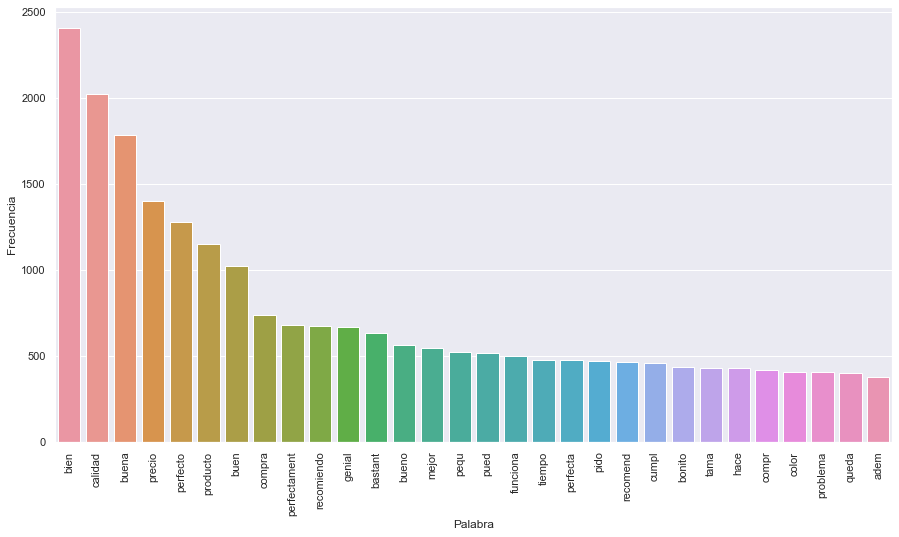

In [90]:
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = frecuencias.iloc[:30].Palabra, y = frecuencias.iloc[:30].Frecuencia)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

Finalmente en la observamos que la palabras co más frecuencia en las críticas con 5 estrellas son: "bien", "calidad" y "precio"

## Breves Conclusiones sobre la primer parte del análisis exploratorio de datos.
Luego de analizar la cantidad de palabras por críticas y su relación con las calificaciones, podemos afirmar que no son una variable que aporte información relevante para la predicción de las calificaciones. La distribuciones según las diferentes calificaciones son homogéneas, por lo tanto no podemos afirmar, por ejemplo,  que una crítica con pocas palabras tenga más o menos probabilidades de ser una crítica mala o buena.
Por otro lado, al analizar las frecuencias de las palabras por número de estrella calificada, encontramos que se repiten 3 palabras en todas las calificaciones: "bien", "calidad" y "producto". Como son palabras con mucha frecuencia, distribuidas de manera homogénea en relación a las diferetes calificaciones, no aportan información relevante para realizar una predicción precisa. Deberíamos encontrar aquellas palabras que hacen la diferencia al momento de calificar. 
Otra caratacterística que no parece aportar mucha información son las diferentes categorías de prodcutos. El promedio y la media de las calificaciones varían en un margen de 2,7 a 3,4 como mínimo y máximo respectivamente, por tipo de producto. En este sentido, no hay tipos de productos que tengan una tendencia a ser calificados con alguna cantidad de estrellas en particular.
De todas formas, vamos a continuar maneniendo las variables explicadas y luego evaluaremos su importancia según el modelo elegido.

### Codificando variables categóricas
Vamos utilizar la función get_dummies para codificar la variable categórica "product_category" a una variable binaria para poder utilizar los modelos de predicción.

In [91]:
# Intanciamos al función de pandas get_dummies
reg = pd.get_dummies(df.product_category, drop_first=False)
df = df.join(reg)

In [92]:
# Vemos al dataframe con las nuevas variables
df.head()

,product_id,reviewer_id,stars,product_category,text_length,nb_words,criticas_stem,apparel,automotive,baby_product,...,other,pc,personal_care_appliances,pet_products,shoes,sports,toy,video_games,watch,wireless
6468,0773990,0443238,1,home,101,21,espera llegu tre fecha entrega primera pasa am...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14064,0019996,0925676,1,home,325,61,producto bien montar precio razon compr nico p...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20862,0301699,0468082,1,apparel,77,15,despu mese recibido diadema devuelto dinero,1,0,0,...,0,0,0,0,0,0,0,0,0,0
35994,0778859,0824370,1,pc,44,7,mandan culo haberlo pagado,0,0,0,...,0,1,0,0,0,0,0,0,0,0
27746,0261843,0782745,1,toy,111,22,producto llegado llegar mayo sigo esperando es...,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [93]:
# Retiramos la variable categórica
df = df.drop('product_category', axis=1)

In [94]:
df.shape

(50000, 36)

In [95]:
#df['critica_negativa'] = df['stars'].apply(lambda x: 1 if x < 5 else 0)

In [96]:
#mas_frec = list(mas_frec.Palabra)
#mas_frec

# Vectorizando las palabras.
Utilizaremos la función de Sklearn count_vectorizer con el objetivo de generar un un vector con las diferentes palabras de las críticas luego de ser procesadas, stemizadas y tokenizadas.  

In [97]:
# Tomamos las palabras de las críticas y hacemos una lista con ellas
lista_criticas = list(df['criticas_stem'].values)

In [98]:
# Usaremos solo las 1000 palabras con mas frecuencia en todo el corpus para generar los vectores
max_features=1000

In [99]:
# Es decir que cada instancia tendrá 1000 features
cou_vec=CountVectorizer(max_features=max_features)

In [100]:
# Realizamos una matriz con las palabras con la función ya instanciada
matriz_criticas = cou_vec.fit_transform(lista_criticas)

In [101]:
# Tomamos las palabras 
all_words = cou_vec.get_feature_names()


In [102]:
# Vizualizamos las 50 palabras mas usadas
print("50 palabras mas usadas: ",all_words[0:50])

50 palabras mas usadas:  ['abajo', 'abierta', 'abierto', 'abr', 'abrir', 'absoluto', 'acaba', 'acabado', 'acabo', 'accesorio', 'aceit', 'acept', 'aconsejo', 'adapta', 'adaptador', 'adecuada', 'adecuado', 'adem', 'adema', 'adhesivo', 'agarr', 'agrad', 'agua', 'aguanta', 'agujero', 'ahora', 'air', 'ajust', 'ajusta', 'ajustan', 'alguien', 'alguna', 'alta', 'altavoz', 'alto', 'altura', 'amazon', 'amo', 'ancha', 'ancho', 'anterior', 'anuncio', 'apaga', 'apagado', 'aparato', 'aparec', 'apart', 'apena', 'aplicaci', 'aplicacion']


## Modelo

Vamos a instanciar las variables independientes y la variable respuesta. EN este caso las variables independientes serán todas las variables menos la calificación en estrellas, que será nuestra variable respuesa o a predecir.

#### Métricas
Como métrica para evaluar el rendimiento de los modelos utilizaremos la Accuracy o exactitud. Corresponde a la fracción de muestras que fueron correctamente clasificadas por los modelos de clasificación.  Se obtiene mediante la siguiente fórmula:

(VP + VN) / ( VP + VN + FP + FN)

La exactitud nos da una idea general de la eficiencia del clasificador, para entender un poco mejor realizaremos un cuadro con otras métricas como precisión, recall y F1-score. 


In [103]:
# Instanciamos las variables
X = matriz_criticas.toarray()
y = df.stars

In [104]:
# Hacemos un train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Modelo Benchmark
Como modelo de refencia para evaluar los diferentes modelos predictivos utilizaremos la probabilidad de acertar el número de estrellas según el azar. Sabemos que la calificación se da sobre un número posible de estrellas (n = 5) y el suceso o ocurrencia posible es una sola. Por lo tanto, la probabilidad de acertar la calificación será la razón entre 1 y 5. 

In [105]:
#Instanciamos el modelo benchmark
benchmark = 1/5

In [106]:
# Definimos una función que nos permita gráficar la matriz de confusión a fin de evaluar los modelos 
def confusion(y_test,y_pred):
    names=['1','2', '3', '4', '5']
    cm=confusion_matrix(y_test,y_pred)
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return

Como primer modelo utilizaremos el GaussianNB, el cual asume que las variables se distribuyen de forma gaussiana o normal. 

In [107]:
# Instanciamos el modelo
nb = GaussianNB()

In [108]:
# Entrenamos con los datos de entrenamiento
nb.fit(X_train, y_train)

GaussianNB()

In [109]:
# Imprimimos la métrica elegida (accuracy)
print("La exactitud del modelo GaussianNM es : ", nb.score(X_test, y_test))

La exactitud del modelo GaussianNM es :  0.3659


Obtuvimos una exactitud de 0.3659. El siguiente paso es realizar una matriz de confusión para evaluar la clasificación que realizó el modelo.

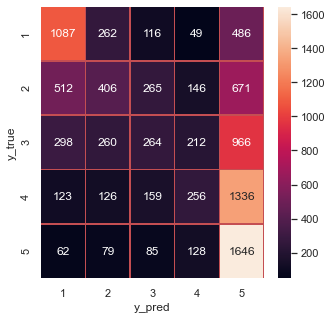

In [110]:
# Realizamos la matriz
y_pred=nb.predict(X_test)
confusion(y_test,y_pred)

A simple vista podemos notar que el modelo clasifica de manera correcta dos etiquetas más que el resto. Las etiquetas con mayores verdaderos positivos son con 1 y 5 estrellas.
Otro dato importante es que el modelo clasifica muchas criticas con 3 y 4 estrellas como si fueran de 5, es decir que es donde encuentra más dificultado para discernir. 
Vamos a utilizar la función classification report de Sklearn para obtener métricas más precisas.

In [111]:
# Imprimimos los resultados
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['1', '2', '3', '4', '5']))


Classification Report

              precision    recall  f1-score   support

           1       0.52      0.54      0.53      2000
           2       0.36      0.20      0.26      2000
           3       0.30      0.13      0.18      2000
           4       0.32      0.13      0.18      2000
           5       0.32      0.82      0.46      2000

    accuracy                           0.37     10000
   macro avg       0.36      0.37      0.32     10000
weighted avg       0.36      0.37      0.32     10000



Podemos ver en los resultados, que las mejores métricas se obtienen en las clasificaciones con 1 y 5 estrellas, por lo que podemos pensar que llevar las clasificaciones a etiquetas binarias sería una manera de obener mejores resultados.

Vamos a realiza el mismo procedimiento con otro modelo, Random Forest de Sklearn.

In [112]:
# Instanciamos el modelo
rf = RandomForestClassifier(random_state=42)

In [113]:
# Entrenamos con los datos de entrenamiento
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [114]:
# Imprimimos la métrica elegida (accuracy)
print("La exactitud del modelo Random Forest Classifier es : ", nb.score(X_test, y_test))

La exactitud del modelo Random Forest Classifier es :  0.3659


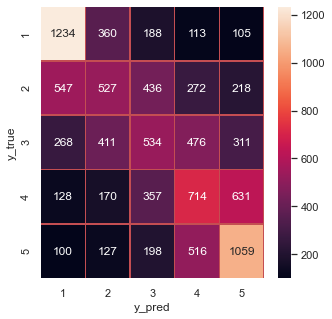

In [115]:
# Realizamos la matriz de confusión
y_pred=rf.predict(X_test)
confusion(y_test,y_pred)

Nuevamente en la matriz de confusión podemos observar que las etiquetas con mayor precisión fueron con 1 y 5 estrellas. A diferencia del caso anterior, la etiqueta con mayor cantidad de verdaderos positivos fueron las clasificaciones con 1 estrella.

In [116]:
# Imprimimos los resultados
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['1', '2', '3', '4', '5']))


Classification Report

              precision    recall  f1-score   support

           1       0.54      0.62      0.58      2000
           2       0.33      0.26      0.29      2000
           3       0.31      0.27      0.29      2000
           4       0.34      0.36      0.35      2000
           5       0.46      0.53      0.49      2000

    accuracy                           0.41     10000
   macro avg       0.40      0.41      0.40     10000
weighted avg       0.40      0.41      0.40     10000



En la tabla anterior confirmamos lo dicho sobre la matriz de confusión. Las tres métricas tienen valores superiores en las calificaciones con 1 y 5 estrellas.

### Optimización de hiperparámetros 
Vamos a realizar una optimización de hiperparámetros del modelo de Random Forest mediante la función de Random Search de Sklearn 

In [117]:
# Instanciamos el modelo de árboles random.
rf_rs = RandomForestClassifier(random_state=42)

In [118]:
# Número de árboles. Realizamos un rango de valores mediante la función de numpay linspace
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 300, num = 10)]
# Número de variables a considerar en cada división de los nodos. Si es "auto", la cantidad es igual a n_variables (13) y si es 'sqrt' es sqrt(n_variables)
max_features = ['auto', 'sqrt']
# Máximo número de niveles en el árbol
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Mínimo número de muestras para dividir un nodo
min_samples_split = [2, 5, 10]
#  Mínimo número de muestras requerido en cada nodo
min_samples_leaf = [1, 2, 4]
#  Método de selección de muestras para entrenar cada árbol.
bootstrap = [True, False]
# Creamos la grilla
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [10, 42, 74, 106, 138, 171, 203, 235, 267, 300], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [119]:
# Usamos la grilla para buscar los mejores hiperparámetros
# Primero creamos el modelo base para optimizar

# Random search de hiperparámtros usando una validación cruzada  de 3 K-folds
rf_random = RandomizedSearchCV(estimator = rf_rs, param_distributions = random_grid, n_iter = 5, cv = 3, verbose=2, n_jobs = -1, random_state=42)

In [120]:
# Entrenamos
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:  3.9min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  6.7min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 42, 74, 106, 138,
                                                         171, 203, 235, 267,
                                                         300]},
                   random_state=42, verbose=2)

In [121]:
# Imprimimos los mejores parámetros y el mejor rendimiento obtenido en r2
print("Mejores parametros: "+str(rf_random.best_params_))
print("Mejor Score: "+str(rf_random.best_score_)+'\n')

Mejores parametros: {'n_estimators': 138, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 80, 'bootstrap': False}
Mejor Score: 0.42754993991093965



In [122]:
scores = pd.DataFrame(rf_random.cv_results_)
scores

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,25.640165,1.817828,0.502369,0.035314,10,10,2,sqrt,50,True,"{'n_estimators': 10, 'min_samples_split': 10, ...",0.407005,0.400660,0.409210,0.405625,0.003624,5
1,223.810328,2.144089,3.202322,0.312461,74,10,4,sqrt,90,False,"{'n_estimators': 74, 'min_samples_split': 10, ...",0.424779,0.422636,0.426236,0.424550,0.001479,2
2,199.245011,4.368334,2.777064,0.184644,74,2,2,auto,60,False,"{'n_estimators': 74, 'min_samples_split': 2, '...",0.425079,0.421511,0.425486,0.424025,0.001786,3
3,168.977630,47.280877,3.115000,0.719385,203,5,1,sqrt,30,True,"{'n_estimators': 203, 'min_samples_split': 5, ...",0.416079,0.413560,0.417160,0.415600,0.001508,4
4,173.038260,4.933790,2.224186,0.145145,138,10,1,auto,80,False,"{'n_estimators': 138, 'min_samples_split': 10,...",0.429954,0.425336,0.427361,0.427550,0.001890,1


In [123]:
# Definimos una función para evaluar la mejora en el rendimiento con los hiperparámetros elegidos mediante Random Search
def evaluando(modelo, test_features, test_labels):
    predictions = modelo.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Performance del modelo')
    print('Error promedio: {:0.4f} grados.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [124]:
# Instanciamos el modelo base
base_model = RandomForestClassifier(random_state=42)


In [125]:
# Entrenamos el modelo
base_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [126]:
# Instanciamos la función con el modelo base
base_accuracy = evaluando(base_model, X_test, y_test)

Performance del modelo
Error promedio: 0.9126 grados.
Accuracy = 59.66%.


In [127]:
# Evaluamos con el mejor estimador
best_random = rf_random.best_estimator_
random_accuracy = evaluando(best_random, X_test, y_test)

Performance del modelo
Error promedio: 0.8684 grados.
Accuracy = 63.79%.


In [128]:
#Imprimimos la mejora
print('La mejora luego de optimizar los hiperparámetros es de {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

La mejora luego de optimizar los hiperparámetros es de 6.91%.


In [129]:
# Le preguntamos la importancia de cada feature (cada palabra)
importances = best_random.feature_importances_
# Tomamos la lista de palabras
all_words = cou_vec.get_feature_names()
columns = all_words

# Ordenamos por importnacia y tomamos las 20 primeras
indices = np.argsort(importances)[::-1]
indices = indices[:20]
selected_columns = [columns[i] for i in indices]
selected_importances = importances[indices]

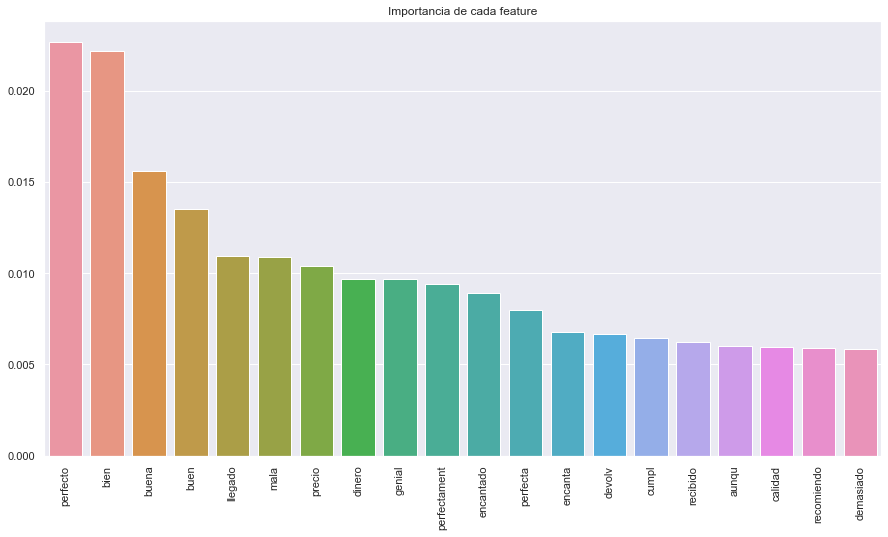

In [130]:
# Por ultimo graficamos
plt.figure(figsize = (15,8))
plt.title('Importancia de cada feature')
plt.xticks(rotation = 90)
sns.barplot(selected_columns, selected_importances)
plt.show()

En el gráfico podemos observar las palabras que tuvieron más relevancia para realizar las predicciones.

Vamos a realizar una matriz de confusión para evaluar cómo predijo el modelo las etiquetas.

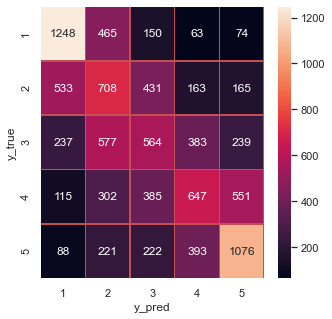

In [131]:
y_pred=best_random.predict(X_test)
confusion(y_test,y_pred)

Nuevamente las etiquetas que obtuvieron más verdadero positivos fueron las que calificaciones con 1 y 5 estrellas.

In [132]:
# Imprimimos los resultados
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['1', '2', '3', '4', '5']))


Classification Report

              precision    recall  f1-score   support

           1       0.56      0.62      0.59      2000
           2       0.31      0.35      0.33      2000
           3       0.32      0.28      0.30      2000
           4       0.39      0.32      0.35      2000
           5       0.51      0.54      0.52      2000

    accuracy                           0.42     10000
   macro avg       0.42      0.42      0.42     10000
weighted avg       0.42      0.42      0.42     10000



En la tabla anterior confirmamos lo dicho sobre la matriz de confusión. Las tres métricas tienen valores superiores en las calificaciones con 1 y 5 estrellas.

### Modelo LinearSVC

Utilizaremos como modelo el LinearSVC de SKlearn con la misma metodología utilizada con los anteriores.

In [133]:
# Notar que en vez de utilizar SVC, vamos a usar LinearSVC. 
# Para el Kernel Lineal, esta función es MUCHO mas rapida que la tradicional SVC.
svc = LinearSVC()

In [134]:
# Entrenamos el modelo
svc.fit(X_train, y_train)

LinearSVC()

In [135]:
# Imprimimos la métrica elegida (accuracy)
print("La exactitud del modelo LinearSVC es : ", svc.score(X_test, y_test))

La exactitud del modelo LinearSVC es :  0.4486


Realizamos la matriz

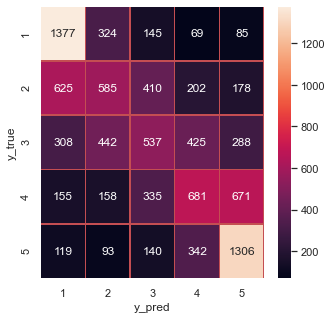

In [136]:
y_pred=svc.predict(X_test)
confusion(y_test,y_pred)

In [137]:
# Imprimimos los resultados
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['1', '2', '3', '4', '5']))


Classification Report

              precision    recall  f1-score   support

           1       0.53      0.69      0.60      2000
           2       0.37      0.29      0.32      2000
           3       0.34      0.27      0.30      2000
           4       0.40      0.34      0.37      2000
           5       0.52      0.65      0.58      2000

    accuracy                           0.45     10000
   macro avg       0.43      0.45      0.43     10000
weighted avg       0.43      0.45      0.43     10000



En la tabla anterior confirmamos lo dicho sobre la matriz de confusión. Las tres métricas tienen valores superiores en las calificaciones con 1 y 5 estrellas.

### Optimización de hiperparámetros 
Vamos a realizar una optimización de hiperparámetros del modelo de SVC mediante la función de Random Search de Sklearn 

In [138]:
# Instanciamos el modelo
svc = LinearSVC()

In [139]:
# Generamos la grilla
# C: regularización. Peso asignado a los errores. Si es alto, clasifica todos los puntos de manera correcta, pero aumenta la posibilidad de sobre ajuste. 
C = [0.1,1, 10, 100]


# Creamos la grilla
random_grid = {'C': C
               }
print(random_grid)

{'C': [0.1, 1, 10, 100]}


In [140]:
# Usamos la grilla para buscar los mejores hiperparámetros
# Primero creamos el modelo base para optimizar
# Random search de hiperparámtros usando una validación cruzada  de 3 K-folds
svc_random = RandomizedSearchCV(estimator = svc, param_distributions = random_grid, n_iter = 5, cv = 3, verbose=2, n_jobs = -1, random_state=42)

In [141]:
# Entrenamos
svc_random.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:  1.4min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.9min finished


RandomizedSearchCV(cv=3, estimator=LinearSVC(), n_iter=5, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100]},
                   random_state=42, verbose=2)

In [142]:
# Imprimimos los mejores parámetros y el mejor rendimiento obtenido en r2
print("Mejores parametros: "+str(svc_random.best_params_))
print("Mejor Score: "+str(svc_random.best_score_)+'\n')

Mejores parametros: {'C': 0.1}
Mejor Score: 0.4421750468015488



In [143]:
scores = pd.DataFrame(svc_random.cv_results_)
scores

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,29.696368,1.617311,0.839062,0.277281,0.1,{'C': 0.1},0.440303,0.442586,0.443636,0.442175,0.001391,1
1,81.830926,0.470147,0.640048,0.065105,1,{'C': 1},0.438428,0.441536,0.442286,0.440750,0.001670,3
2,81.690848,9.050061,0.386694,0.125931,10,{'C': 10},0.439328,0.443411,0.442661,0.441800,0.001775,2
3,56.654627,18.605223,0.110341,0.006018,100,{'C': 100},0.393205,0.393760,0.402385,0.396450,0.004203,4


In [144]:
# Instanciamos el modelo base para calcular la mejora
base_model =  LinearSVC()

In [145]:
# Entrenamos el modelo
base_model.fit(X_train, y_train)

LinearSVC()

In [146]:
# Instanciamos la función con el modelo base
base_accuracy = evaluando(base_model, X_test, y_test)

Performance del modelo
Error promedio: 0.8355 grados.
Accuracy = 64.46%.


In [147]:
# Evaluamos con el mejor estimador
best_random = svc_random.best_estimator_
random_accuracy = evaluando(best_random, X_test, y_test)

Performance del modelo
Error promedio: 0.8324 grados.
Accuracy = 64.77%.


In [148]:
#Imprimimos la mejora
print('La mejora luego de optimizar los hiperparámetros es de {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

La mejora luego de optimizar los hiperparámetros es de 0.48%.


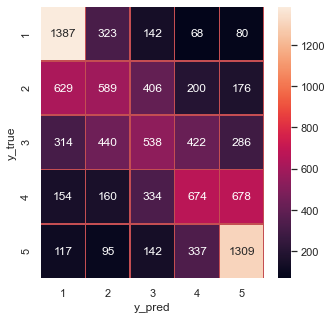

In [149]:
# Realizamos la matriz de confusión
y_pred=best_random.predict(X_test)
confusion(y_test,y_pred)

Se repite el patrón para el modelo LinearSVC, las categorías con más verdaderos positivos son las clasificaciones con 1 y 5 estrellas

In [150]:
# Imprimimos los resultados
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['1', '2', '3', '4', '5']))


Classification Report

              precision    recall  f1-score   support

           1       0.53      0.69      0.60      2000
           2       0.37      0.29      0.33      2000
           3       0.34      0.27      0.30      2000
           4       0.40      0.34      0.36      2000
           5       0.52      0.65      0.58      2000

    accuracy                           0.45     10000
   macro avg       0.43      0.45      0.43     10000
weighted avg       0.43      0.45      0.43     10000



Los resultados de las 3 métricas elegias confirman lo visto en la matriz de confusión

### Comparando los modelos
vamos a generar una función que nos permita evaluar y comparar los 3 modelos con el fin de elegir el más exacto.

In [151]:
# Definimos la función para RSME
def comparar_modelos(train, label):
    results={}
    def test_model(clf):
        
        y_test_pred = clf.predict(train)
        accuracy_test = accuracy_score(label, y_test_pred)
        return accuracy_test


    
    clf = benchmark
    results["Benchmark"]= benchmark
    
    clf = nb
    results["Naive Bayes"]=test_model(clf)
    
    clf = rf_random.best_estimator_
    results["Random Forest"]=test_model(clf)
    
    clf = svc_random.best_estimator_
    results["Linear svc"]=test_model(clf)

        
    
    results = pd.DataFrame.from_dict(results, orient='index')
    results.columns=['Accuracy']
    results = pd.DataFrame(results['Accuracy'].sort_values(ascending=False))
    results.plot(kind="bar",title="Model Scores")
    axes = plt.gca()
    
    return results

,Accuracy
Linear svc,0.4497
Random Forest,0.4243
Naive Bayes,0.3659
Benchmark,0.2000


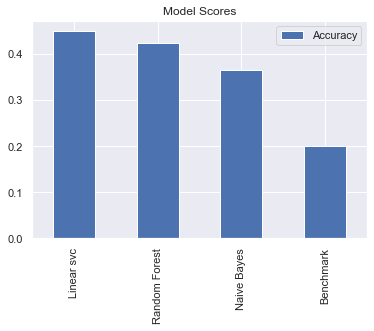

In [152]:
comparar_modelos(X_test, y_test)

Según lo observado en el gráfico, el modelo que mejor se ajusta al problema es el LinearSVC con una exactitud aprox de 45%, más del doble del modelo Benchmark elegido. 

### Conclusiones sobre los resultados

Luego de probar los modelos elegidos podemos afirmar que, sobre la base de las métricas elegidas el modelo que mejor clasifica el número de estrellas es el LinearSVC.
En relación a los resultados obtenidos en las matrices de confusión, podríamos obtener mejores resultados si llevamos las calificaciones a variables categóricas binarias, positivas o negativas.
Todos los modelos clasifican mejor en ambos extremos de las críticas, con 1 y 5 estrellas y tienen problemas en clasificar las críticas con 2 y 4 estrellas. 
Asimismo, se pueden realizar análisis más profundos sobre qué palabras se asocian a valores positivos y negativos. Se podrían utilizar otras técnicas de análisis para entender la sensibilidad del modelo al clasificar las críticas.
Posiblemente se obtengan mejores resultados al tener una frontera de decisión más simple. 

### Temas a trabajar e investigar para el proyecto final

Como objetivo para el trabajo final propongo los siguientes objetivos

1. Utilizar las biblioteca SPacy para Lemmatizar en español.

2. Realizar un TF-IDF utilizando como guía el capítulo 6.3 Word Frequencies with TfidfVectorizer, del libro "Deep Learning for Natural Language Processing" de Jason Brownlee

3. Llevar las variables a clasificar a un tipo binario de críticas positivas y negativas y comparar resultados.

4. Sumar el Modelos XGBoostClassifier para comparar rendimientos.


### Adelanto para el trabajo final
A continuación realizaremos una prueba con las variables discretas a variables binarias, es decir si son críticas positivas o negativas. 
Si bien con una columna es suficiente, generamos dos para facilitar luego el análisis exploratorio.

In [162]:
# Pasamos las variables multiclase a binarias
df['critica_negativa'] = df['stars'].apply(lambda x: 1 if x < 5 else 0)
df['critica_positiva'] = df['stars'].apply(lambda x: 0 if x < 5 else 1)

In [154]:
df.head()

,product_id,reviewer_id,stars,text_length,nb_words,criticas_stem,apparel,automotive,baby_product,beauty,...,personal_care_appliances,pet_products,shoes,sports,toy,video_games,watch,wireless,critica_negativa,critica_positiva
6468,0773990,0443238,1,101,21,espera llegu tre fecha entrega primera pasa am...,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
14064,0019996,0925676,1,325,61,producto bien montar precio razon compr nico p...,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
20862,0301699,0468082,1,77,15,despu mese recibido diadema devuelto dinero,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
35994,0778859,0824370,1,44,7,mandan culo haberlo pagado,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
27746,0261843,0782745,1,111,22,producto llegado llegar mayo sigo esperando es...,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [155]:
# Instanciamos las variables
X = matriz_criticas.toarray()
y = df.critica_negativa

In [156]:
# Hacemos un train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [159]:
# Instanciamos el modelo
svc = LinearSVC()

In [160]:
# Entrenamos
svc.fit(X_train, y_train)

LinearSVC()

In [161]:
# Imprimimos la métrica elegida (accuracy)
print("La exactitud del modelo LinearSVC es : ", svc.score(X_test, y_test))

La exactitud del modelo LinearSVC es :  0.8351


Obtuvimos un mejor resultado, aún sin optimizar los hiperparámetros del modelo. Posiblemente sea un buen comienzo para continuar desarrollando en el trabajo final.